# PyTorch Computer Vision Model Practice
Creating a series of neural networks that can be used to identify the types of items of clothing in the **Fashion MNIST** dataset.

This project was coded on google colab

*Author: Kiran Ravi*

*17/11/24*

In [2]:
# Import required libraries

# Import PyTorch
import torch
from torch import nn

# Import TorchVision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualisation
import matplotlib.pyplot as plt

# Import tqdm for progress bars
from tqdm.auto import tqdm


# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


In [3]:
# Import torch metrics and mlxtend for accuracy and confusion matrix metrics

# Check if required packages are in google colab, and if not, import
try:
  import torchmetrics as tm
  import mlxtend as mlx
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version needs to be 0.19.0 or higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics as tm
  import mlxtend as mlx
  print(f"mlxtend version: {mlx.__version__}")


  from torchmetrics.classification import MulticlassAccuracy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 41.9 MB/s eta 0:00:00
mlxtend version: 0.23.3


In [4]:
# Check if gpu is available
torch.cuda.is_available()

True

# Import vision dataset
- For initial model development, we will be using the FashionMNIST Dataset
- The goal with this model is to classify the images into various kinds of clothing

Fashion MNIST is included in the torch vision package

In [5]:
# Setup training and testing data
train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),   # Convert data from PIL to tensor
    target_transform = None
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
    target_transform = None
)


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.7MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 175kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.19MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 7.93MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [6]:
# Check input and output shapes of data
image, label = train_data[0]
class_names = train_data.classes

print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image label: {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label: Ankle boot


(-0.5, 27.5, 27.5, -0.5)

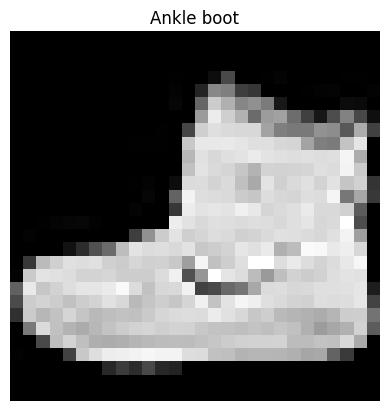

In [7]:
# Visualise the data
plt.imshow(image.squeeze(), cmap="grey")
plt.title(class_names[label])
plt.axis(False)

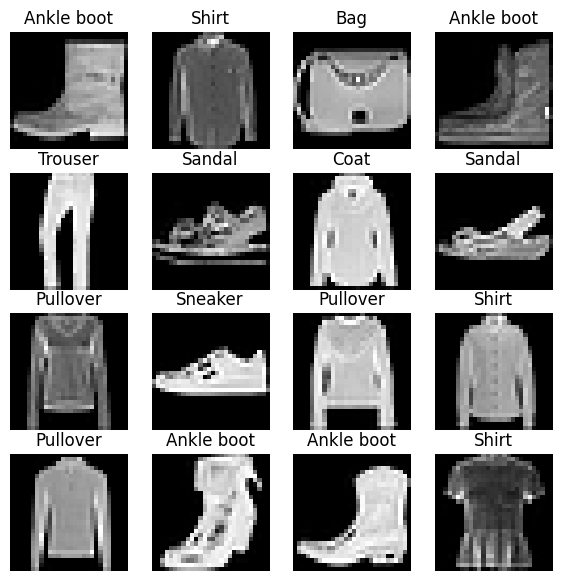

In [8]:
# Plot more images with labels
torch.manual_seed(42)

# 4x4 figure of random images from the training data
fig = plt.figure(figsize=(7,7))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  rand_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[rand_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="grey")
  plt.title(class_names[label])
  plt.axis(False);

## Prepare DataLoader
- This turns our data into a python iterable
- We want to convert our data into mini batches for efficient memory usage

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32 # Hyperparam

# Setup the dataloader
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                              batch_size = BATCH_SIZE,
                              shuffle = False)

# Create Baseline Model - Model 0
Starting point model from which we can improve, simple linear model for now

In [10]:
# Baseline model creation
class FMNISTModelV0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                 out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
        )

  def forward(self,x):
    return self.layer_stack(x)


In [11]:
# Create a function to time the training process
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device = None):
  """
  Prints difference between start and end times for NN model

  start (float): time at which the training process starts
  end (float): time at which the training process ends
  device (torch.device): the device on which the model was trained (cpu or gpu)
  """

  total_time = end-start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

# Create model eval function

In [12]:
def eval_model( model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                device):
  """
    Returns a dictionary containing the results of model predicting on data_loader.

    model (torch.nn.Module): Model to be evaluated
    data_loader (torch.utils.data.DataLoader): loader containing the data on which the model carries out predictions
    loss_fn (torch.nn.Module): loss function
    device: device on which the model is stored (cpu or gpu)
  """

  loss, acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):

      X,y = X.to(device), y.to(device)

      # Forward Pass
      y_pred = model(X)

      # Calculate the loss
      loss += loss_fn(y_pred, y)
      # acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim=1))

      accuracy_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device)
      acc += accuracy_fn(y_pred.argmax(dim=1), y)

    # Scale the loss and acc to per batch
    loss /= len(data_loader)
    acc /= len(data_loader)


  return {"Model Name": model.__class__.__name__,
          "Model Loss": loss.item(),
          "Model Accuracy": round(acc.item(),4)}

## Model 1: Non-linear model

In [13]:
# V1 model creation with non-linearity
class FMNISTModelV1(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                 out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.ReLU()
        )

  def forward(self, x : torch.Tensor):
    return self.layer_stack(x)

# Model 2: Creating a convolutional network

In [14]:
# Create a new model
class FMNISTModelV2(nn.Module):
  """
  Model architecture that replicates TinyVGG model from CNN explainer website
  """

  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    # Construct convolutional blocks
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                    stride = 2)
      )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                    stride = 2)
        )

    # Construct classifier block
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*7*7,  # 7s are found by printing the output shapes of the conv layers, and using them to match the expected in shape for linear
                  out_features = output_shape)

    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)

    x = self.conv_block_2(x)
    # print(x.shape)

    x = self.classifier(x)
    # print(x.shape)

    return(x)



# Functionise Training and Testing loops


In [15]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  """
    Performs training step with model trying to learn on data loader
  """

  train_loss, train_acc = 0, 0

  model.to(device)

  # Print what device the data is on
  print(f"Data is on {device}")


  # Put model into training mode
  model.train()

  # Add a loop to loop through training batches
  for batch, (X, y) in enumerate(data_loader):

    # Put data on the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward Pass
    y_hat = model(X)

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_hat, y)
    train_loss += loss

    # Setup torch metrics accuracy
    accuracy_fn = MulticlassAccuracy(num_classes = len(class_names)).to(device)
    train_acc += accuracy_fn(y_hat.argmax(dim=1), y)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # Optimizer step, step, step - optimizer is being stepped once per batch
    optimizer.step()

    # Print out whats happening
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(data_loader.dataset)} samples")

  # Divide total train loss and accuracy by the length of the dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}\n")

In [16]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
    """
      Performs testing step and calculates testing loss and accuracy
    """
    test_loss, test_acc = 0, 0

    model.to(device)

    # Set the model to eval mode
    model.eval()
    with torch.inference_mode():
      for X, y in data_loader:

        # Put data on the target device
        X = X.to(device)
        y = y.to(device)

        # Forward Pass
        test_pred = model(X)

        # Calculate Loss and accuracy
        loss = loss_fn(test_pred, y)
        test_loss += loss

        accuracy_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device)
        test_acc += accuracy_fn(test_pred.argmax(dim=1), y)

      # Calculate the avg test loss per batch
      test_loss /= len(data_loader)

      # Calculate avg acc per batch
      test_acc /= len(data_loader)

      # Print out whats happenin
      print(f"\nTest loss: {test_loss:.5f} | Test acc: {test_acc:.2f}\n")

# Instantiate and train all 3 models
- Model 0 - Run on CPU
- Model 1 - Run on GPU
- Model 2 - Run on GPU

In [17]:
# Instantiate models
torch.manual_seed(42)
model_0 = FMNISTModelV0(784, 10, len(class_names))
model_1 = FMNISTModelV1(28*28, 10, len(class_names))
model_2 = FMNISTModelV2(1, 10, len(class_names))

In [18]:
# Train and test model 0

# Set up optimizer and loss functions
loss_fn = nn.CrossEntropyLoss()
optimizer_0 = torch.optim.SGD(params = model_0.parameters(), lr=0.1)

# Set manual seeds
torch.manual_seed(42)

# Start timer
train_time_start_model_0 = timer()

# Set device
device = "cpu"

# Set the number of epochs
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")

  # Run train function
  train_step(model_0, train_dataloader, loss_fn, optimizer_0,  device)

  # Run test function
  test_step(model_0, test_dataloader, loss_fn,  device)


# Calculate the training time
train_time_end_model_0 = timer()

model_0_time = print_train_time(start = train_time_start_model_0,
                 end = train_time_end_model_0,
                 device = str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Data is on cpu
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.59039 | Train acc: 0.78


Test loss: 0.50954 | Test acc: 0.81

Epoch: 1
------
Data is on cpu
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.47633 | Train acc: 0.82


Test loss: 0.47989 | Test acc: 0.82

Epoch: 2
------
Data is on cpu
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.45503 | Train acc: 0.83


Test loss: 0.47664 | Test acc: 0.82

Train time on cpu: 41.760 seconds


In [19]:
# Train and test model 1

# Set up optimizer for model 1
optimizer_1 = torch.optim.SGD(params = model_1.parameters(), lr=0.1)

# Set manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start timer
train_time_start_model_1 = timer()

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set the number of epochs
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")

  # Run train function
  train_step(model_1, train_dataloader, loss_fn, optimizer_1,  device)

  # Run test function
  test_step(model_1, test_dataloader, loss_fn,  device)


# Calculate the training time
train_time_end_model_1 = timer()

model_1_time = print_train_time(start = train_time_start_model_1,
                 end = train_time_end_model_1,
                 device = str(next(model_1.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Data is on cuda
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.94986 | Train acc: 0.67


Test loss: 0.74784 | Test acc: 0.72

Epoch: 1
------
Data is on cuda
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.70715 | Train acc: 0.73


Test loss: 0.69294 | Test acc: 0.74

Epoch: 2
------
Data is on cuda
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.67508 | Train acc: 0.74


Test loss: 0.69483 | Test acc: 0.74

Train time on cuda:0: 52.529 seconds


In [20]:
# Train and test model 2

# Set up optimizer for model 2
optimizer_2 = torch.optim.SGD(params = model_2.parameters(), lr=0.1)

# Set manual seeds
torch.manual_seed(42)

# Start timer
train_time_start_model_2 = timer()

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set the number of epochs
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")

  # Run train function
  train_step(model_2, train_dataloader, loss_fn, optimizer_2, device)

  # Run test function
  test_step(model_2, test_dataloader, loss_fn, device)


# Calculate the training time
train_time_end_model_2 = timer()

model_2_time = print_train_time(start = train_time_start_model_2,
                 end = train_time_end_model_2,
                 device = str(next(model_2.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Data is on cuda
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.63036 | Train acc: 0.76


Test loss: 0.38462 | Test acc: 0.85

Epoch: 1
------
Data is on cuda
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.34255 | Train acc: 0.87


Test loss: 0.33576 | Test acc: 0.87

Epoch: 2
------
Data is on cuda
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.30625 | Train acc: 0.88


Test loss: 0.30118 | Test acc: 0.89

Train time on cuda:0: 53.134 seconds


In [21]:
# Evaluate model 0 for comparison
model_0_results = eval_model(model_0, test_dataloader, loss_fn, "cpu")
print(model_0_results)
model_0_time = print_train_time(start = train_time_start_model_0,
                 end = train_time_end_model_0,
                 device = str(next(model_0.parameters()).device))

  0%|          | 0/313 [00:00<?, ?it/s]

{'Model Name': 'FMNISTModelV0', 'Model Loss': 0.47663894295692444, 'Model Accuracy': 0.8233}
Train time on cpu: 41.760 seconds


In [22]:
# Evaluate model 1 for comparison
model_1_results = eval_model(model_1, test_dataloader, loss_fn, device)
print(model_1_results)
model_1_time = print_train_time(start = train_time_start_model_1,
                 end = train_time_end_model_1,
                 device = str(next(model_1.parameters()).device))

  0%|          | 0/313 [00:00<?, ?it/s]

{'Model Name': 'FMNISTModelV1', 'Model Loss': 0.6948277950286865, 'Model Accuracy': 0.739}
Train time on cuda:0: 52.529 seconds


In [23]:
# Evaluate model 2 for comparison
model_2_results = eval_model(model_2, test_dataloader, loss_fn, device)
print(model_2_results)
model_2_time = print_train_time(start = train_time_start_model_2,
                 end = train_time_end_model_2,
                 device = str(next(model_2.parameters()).device))

  0%|          | 0/313 [00:00<?, ?it/s]

{'Model Name': 'FMNISTModelV2', 'Model Loss': 0.3011844754219055, 'Model Accuracy': 0.8868}
Train time on cuda:0: 53.134 seconds


# Compare the results across the experiments

In [24]:
import pandas as pd

# Create dataframe for easy visual comparsion
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
train_times = [model_0_time, model_1_time, model_2_time]
model_devices = [str(next(model_0.parameters()).device), str(next(model_1.parameters()).device), str(next(model_2.parameters()).device)]

compare_results['Training Time'] = train_times
compare_results['Model Device'] = model_devices


compare_results

,Model Name,Model Loss,Model Accuracy,Training Time,Model Device
0,FMNISTModelV0,0.476639,0.8233,41.760365,cpu
1,FMNISTModelV1,0.694828,0.7390,52.528582,cuda:0
2,FMNISTModelV2,0.301184,0.8868,53.134478,cuda:0


In [25]:
compare_results.set_index("Model Name", inplace=True)

Text(0.5, 1.0, 'Model Accuracy Comparison')

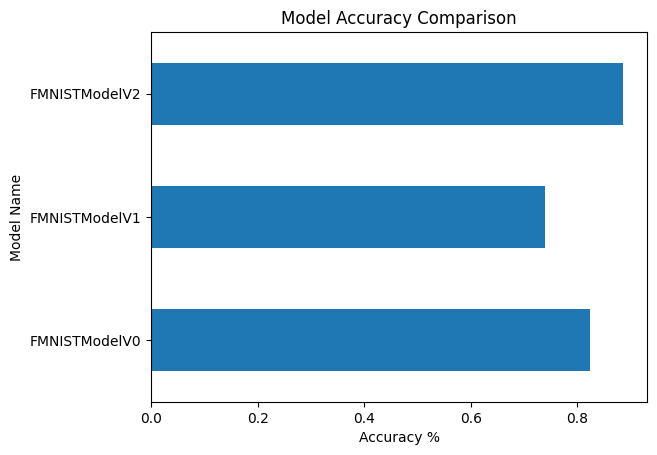

In [26]:
# Visualise model results
compare_results["Model Accuracy"].plot(kind="barh")
plt.xlabel("Accuracy %")
plt.title("Model Accuracy Comparison")

# Do predicitions on random samples from the dataset
Make a prediction with the model and plot the image and the predicted output

In [27]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device):
  """ Runs data through the selected model and outputs a tensor of label probabilities"""
  pred_probs = []

  model.eval()
  with torch.inference_mode():
    for sample in data:

      # Prepare the sample
      sample = sample.unsqueeze(0).to(device)

      # Forward pass
      pred_logit = model(sample)

      # Get prediction probabililty (logit -> prob)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_prob onto cpu for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn the list into a tensor
  return torch.stack(pred_probs)

In [28]:
import random

torch.manual_seed(42)
random.seed(42)
test_samples=[]
test_labels=[]

# Take 9 random samples and labels from the test_data list
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# Predict the probabilites for these samples
pred_probs = make_predictions(model=model_2, data=test_samples, device=device)

# Turn prediction probabilities into prediction labels by taking argmax
pred_labels = pred_probs.argmax(dim=1)

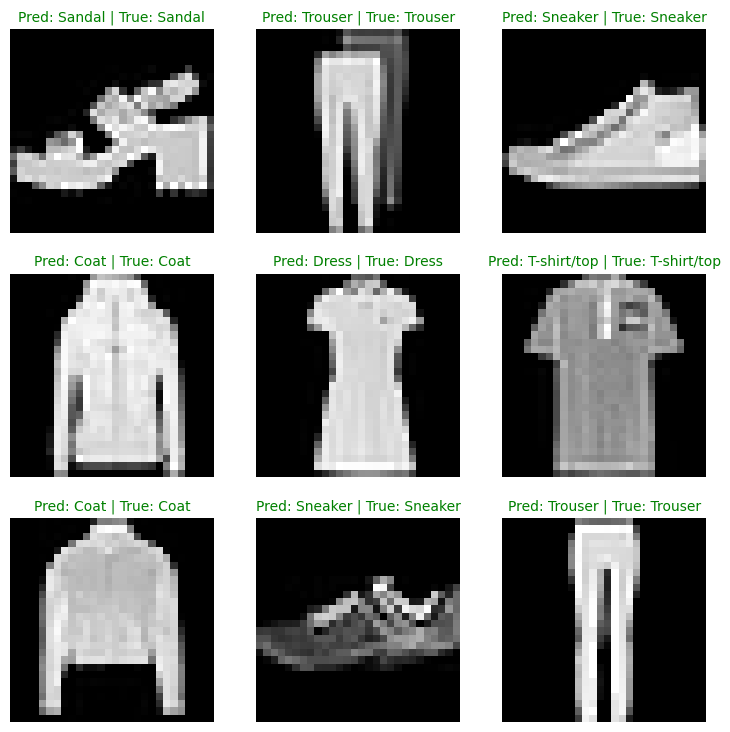

In [29]:
torch.manual_seed(42)
random.seed(42)


# Plot the results of predictions
fig = plt.figure(figsize=(9,9))
rows, cols = 3,3
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(rows, cols, i+1)

  # Plot the sample image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find predicted and true labels
  pred_label = class_names[pred_labels[i]]
  true_label = class_names[test_labels[i]]

  # Title
  title_text = f"Pred: {pred_label} | True: {true_label}"

  # Colour title according to if match or mismatch
  if pred_label == true_label:
    plt.title(title_text, fontsize=10, c="g") # Green if match
  else:
    plt.title(title_text, fontsize=10, c="r") # Red if mismatch

  plt.axis("off")



# Make a confusion matrix and plot

In [30]:
# Make predictions on whole dataset with trained model
y_preds = []

model_2.eval()
with torch.inference_mode():
  for X,y in tqdm(test_dataloader, desc="Making predictions..."):
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_logits = model_2(X)

    # Logits -> prediction probs
    y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)

    # Put predictions on cpu
    y_preds.append(y_pred.cpu())

# Concatenate predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]




Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [31]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Set up confusion matrix
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target = test_data.targets)

confmat_tensor

tensor([[665,   3,  33,  66,   9,   0, 218,   0,   6,   0],
        [  7, 943,   2,  31,  13,   0,   3,   0,   1,   0],
        [  8,   2, 825,  14,  85,   0,  62,   0,   4,   0],
        [ 25,  16,  19, 855,  35,   0,  39,   0,   8,   3],
        [  6,   6, 114,  45, 726,   0, 100,   0,   2,   1],
        [  2,   2,   2,  10,   0, 840,   5,  55,  65,  19],
        [ 86,   6, 114,  63,  90,   0, 631,   0,  10,   0],
        [  1,   0,   0,   1,   0,  22,   0, 929,   7,  40],
        [  7,   3,  16,  17,   6,   6,  22,   8, 913,   2],
        [  1,   0,   1,   2,   1,  28,   4, 101,  16, 846]])

Text(0.5, 1.0, 'Model 2 Confusion Matrix')

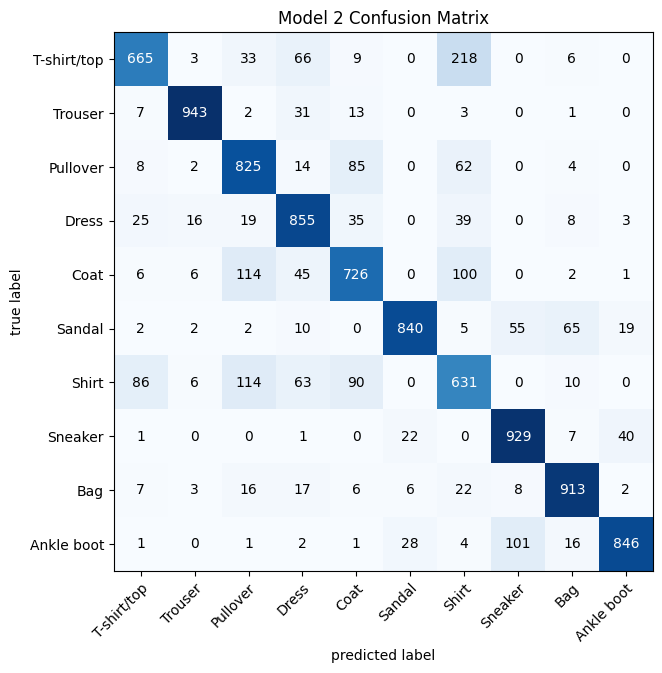

In [32]:
import numpy

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
     conf_mat = confmat_tensor.numpy(),
     class_names = class_names,
     figsize = (10,7)
 )
plt.title("Model 2 Confusion Matrix")

# Save our best performing model

In [33]:
from pathlib import Path
# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True,
                 exist_ok= True)

# Create model save
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [34]:
# Create a new instance to load the model in
torch.manual_seed(42)
loaded_model = FMNISTModelV2(1, 10, len(class_names))


# Load in the saved state dict
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to device
device ="cpu"
loaded_model.to(device)

<ipython-input-34-07b6d37f6e6a>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


FMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [35]:
# Evaluate the loaded model
loaded_results = eval_model(loaded_model, test_dataloader, loss_fn, "cpu")
print("Results for loaded model")
print(loaded_results)

  0%|          | 0/313 [00:00<?, ?it/s]

Results for loaded model
{'Model Name': 'FMNISTModelV2', 'Model Loss': 0.3011845350265503, 'Model Accuracy': 0.8868}


In [36]:
model_2_results

{'Model Name': 'FMNISTModelV2',
 'Model Loss': 0.3011844754219055,
 'Model Accuracy': 0.8868}

In [37]:
# Check that the loaded model is close in performance to the original model
torch.isclose(torch.tensor(model_2_results["Model Loss"]),
              torch.tensor(loaded_results["Model Loss"])).item()

True